<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prelude" data-toc-modified-id="Prelude-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prelude</a></span></li><li><span><a href="#Utilities-(as-before)" data-toc-modified-id="Utilities-(as-before)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Utilities (as before)</a></span></li><li><span><a href="#Finding-Shortest-Path-(as-before)" data-toc-modified-id="Finding-Shortest-Path-(as-before)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Finding Shortest Path (as before)</a></span></li><li><span><a href="#Finding-Shortest-Delivery-Route-(as-before)" data-toc-modified-id="Finding-Shortest-Delivery-Route-(as-before)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finding Shortest Delivery Route (as before)</a></span></li><li><span><a href="#Time-Handling" data-toc-modified-id="Time-Handling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Time Handling</a></span></li><li><span><a href="#Class-Recorder" data-toc-modified-id="Class-Recorder-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Class Recorder</a></span></li><li><span><a href="#Class-Parcel" data-toc-modified-id="Class-Parcel-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Class Parcel</a></span></li><li><span><a href="#Class-Customer" data-toc-modified-id="Class-Customer-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Class Customer</a></span></li><li><span><a href="#Class-Driver" data-toc-modified-id="Class-Driver-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Class Driver</a></span></li><li><span><a href="#Class-Delivery-Centre" data-toc-modified-id="Class-Delivery-Centre-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Class Delivery Centre</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Parameters-from-Specification" data-toc-modified-id="Parameters-from-Specification-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Parameters from Specification</a></span></li><li><span><a href="#Generate-Input-Data" data-toc-modified-id="Generate-Input-Data-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Generate Input Data</a></span></li><li><span><a href="#Simulation-Routine" data-toc-modified-id="Simulation-Routine-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>Simulation Routine</a></span></li><li><span><a href="#Model-Verification" data-toc-modified-id="Model-Verification-11.4"><span class="toc-item-num">11.4&nbsp;&nbsp;</span>Model Verification</a></span></li><li><span><a href="#Adding-Statistics-and-Visualisation" data-toc-modified-id="Adding-Statistics-and-Visualisation-11.5"><span class="toc-item-num">11.5&nbsp;&nbsp;</span>Adding Statistics and Visualisation</a></span></li></ul></li></ul></div>

# Prelude

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pulp
import math
import random
import pandas as pd
import numpy as np
import simpy

# Utilities (as before)

In [2]:
resolution = 10000  # city of about 10km diameter

In [3]:
def plotMap(G, T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=7,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    plt.xlim(0,resolution)
    plt.ylim(0,resolution)
    if not grid:
        plt.axis('off')
    V, E = G
    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if text is not None:
        plt.text(0.8*resolution, 0, text)
    if grid:
        plt.grid()
    plt.show()

# Finding Shortest Path (as before)

In [4]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

In [5]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [6]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

# Finding Shortest Delivery Route (as before)

In [7]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]
    
    def index(x, L):
        for i in range(len(L)):
            if x==L[i]: 
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p               

In [8]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

def createLoop(M, T):
    D, P = createTables(M, T)
    # Matrix of the shortest path between every two points.
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):# The location of the customer is entered only once.
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):# The location of the customer is left only once.
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):# prevent subtour
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    # print(f"{constraints:d} Constraints")
    prob.solve(solver)
    trips = roundtrips(x, n)
    while len(trips)>1:
        for t in trips:
            prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                            for i in range(0,len(t)-1) ]) <= len(t)-2
            constraints += 1
        # print(f"{constraints:d} Constraints")
        prob.solve(solver)
        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
    return loop

# Time Handling

**Convention:** In this project we measure time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`

In [9]:
    def timestamp(t):
        day = int(t)//(24*3600)
        t = t - day*24*3600
        hour = int(t)//3600
        t = t - hour*3600
        mins = int(t)//60
        t = t - mins*60
        secs = int(t)
        t = int(round((t - secs)*10))
        return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [10]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.1'

In [11]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

In [12]:
def day(now):
    return int(now//(24*3600))

# Class Recorder

We willl use a class Recorder as a reference point for capturing data during the simulation. There will be only one recorder. It will be created at the beginning of every simulation run. Every entity will carry a reference to the Recorder. 

In [13]:
class Recorder:
    
    def __init__(self, env, M, W, C, days, 
                 log=False, plot=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.log = log
        self.plot = plot
        Customer.REGISTER = []
        Parcel.REGISTER = []
        
        # create a data frame for time records per working day
        self.daily = pd.DataFrame()
        self.daily['driver_starts'] = [None]*days # The time of the driver starts to work per day
        self.daily['driver_ends'] = [None]*days # The time of the driver ends work per day
        self.daily['distance'] = [None]*days # The route distance per day
        self.daily['leftover'] = [None]*days # The number of leftover parcels per day
        
        
        # create a data frame for time records per parcel
        self.perParcel = pd.DataFrame()
        self.perParcel['arrived'] = [None]*len(Parcel.REGISTER) # The time of the parcel arrived at DC
        self.perParcel['accepted'] = [None]*len(Parcel.REGISTER) # The time of the parcel be accepted by the Customer
        
    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)
            
    def recordTourLength(self, length):
        self.daily.at[day(self.env.now), 'distance'] = length/1000
        
    def recordLeftover(self, n):
        self.daily.at[day(self.env.now), 'leftover'] = int(n)
        
    def recordDriverBeginsWork(self):
        #self.trace("Driver arrives for work")
        self.daily.at[day(self.env.now), 'driver_starts'] = int(round(self.env.now))
        
    def recordDriverEndsWork(self):
        #self.trace("Driver goes home")
        self.daily.at[day(self.env.now), 'driver_ends'] = int(round(self.env.now))
    
    def recordParcelArrived(self,index):
        #self.trace("Parcel has been arrived:")
        self.perParcel.at[index, 'arrived'] = day(self.env.now)
        
    def recordCustomerAccepted(self,index):
        #self.trace("Parcel has been accepted by the customer")
        self.perParcel.at[index, 'accepted'] = day(self.env.now)
        
    def finish(self):
        self.daily['time'] = (self.daily['driver_ends']-self.daily['driver_starts'])/60
        self.perParcel['delay'] = self.perParcel['accepted']-self.perParcel['arrived']

# Class Parcel

<img src='EventGraph Parcel.png' width=500/>

Parcels follow through a sequence of states:
- processing
- in transit (from manufacture to distribution centre)
- arrived in distribution centre
- ready for delivery 
- out for delivery
- customer not present
- returned to distribution centre
- delivered

In [14]:
class Parcel:
    
    REGISTER = []
    
    def __init__(self, rec, i, cust):
        self.rec = rec
        self.i = i  # row index in data frames of input data
        self.dest = cust.location
        self.status = [ 'processing' ] # status record and
        self.timing = [ self.rec.env.now ]      # timing
        assert(len(Parcel.REGISTER)==i)
        Parcel.REGISTER += [ self ] 
    
    # factory method ensures that there is only
    # one Parcel per location
    def getParcel(rec, i, location):
        for p in Parcel.REGISTER:
            if p.i == i:
                return p
        return Parcel(rec, i, location)

    
    def __str__(self):
        return f"Parcel: {self.i:2d}"

    def index(self):
        return self.i
    
    def destination(self):
        return self.dest
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        self.rec.recordParcelArrived(self.i)###################parcel arrived at DC time################
        #print("Parcel "+str(self.i)+" arrived at DC ",int(round(self.rec.env.now)))
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')
    

# Class Customer

<img src='EventGraph Customer.png' width=500/>

In [15]:
class Customer:
    
    REGISTER = []

    def __init__(self, rec, location):
        self.rec = rec
        self.location = location
        self.i = len(Customer.REGISTER)
        Customer.REGISTER += [ self ]
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())
        
    def __str__(self):
        return f"Customer: {self.i:2d} {str(self.location):s}"
    
    # factory method ensures that there is only
    # one customer per location
    def getCustomer(rec, location):
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        return Customer(rec, location)
    
    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        #self.rec.trace(str(self)+" leaves house")
        self.atHome = False
     
    def returnHome(self):
        assert(not self.atHome)
        #self.rec.trace(str(self)+" returns home")
        self.atHome = True
        
    def answerDoor(self):
        if self.atHome:
            yield self.rec.env.timeout(random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR))
            #self.rec.trace(str(self)+" answers door")
            self.answersDoor = True
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            #self.rec(str(self)+" not at home")
            
    def acceptParcel(self, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        #self.rec.trace(str(self)+" accepts "+str(parcel))
        self.rec.recordCustomerAccepted(parcel.i)#######################parcel accepted time############
        #print("customer accepted the Parcel "+str(parcel)+" at time:",int(round(self.rec.env.now)))
        
    def signOff(self):
        assert(self.answersDoor)
        #self.rec.trace(str(self)+" signs off")
        self.answersDoor = False
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))

# Class Driver

<img src='EventGraph Driver.png' width=500/>

In [16]:
class Driver:
    
    def __init__(self, rec, DC):
        self.rec = rec
        self.DC = DC
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        self.rec.recordDriverBeginsWork()########################Driver Starts Work Time#####################
        
    def leaveForDelivery(self, tour, parcels):
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " \
                       f"of {len(parcels):d} parcels")
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels = self.DC.sendForDelivery()
            yield self.rec.env.timeout(PREP_TIME_PER_PARCEL*len(parcels))
            self.rec.recordTourLength(pathLength(tour))######################Route Distance#################
            self.leaveForDelivery(tour, parcels)
            
            while len(self.parcels)>0:
                # drive to customer
                custLocation = self.parcels[0].dest
                cust = Customer.getCustomer(self.rec, custLocation)
                self.rec.trace("Driver drives to "+str(cust))
                yield from self.__drive(custLocation)
                self.rec.trace("Driver arrived at "+str(cust))
                # call at customer
                yield from cust.answerDoor()
                
                if cust.answersDoor:
                    while len(self.parcels)>0 and \
                            custLocation == self.parcels[0].dest:
                        cust.acceptParcel(self.parcels[0])
                        yield self.rec.env.timeout(random.expovariate(1/10))
                        self.parcels = self.parcels[1:]
                    cust.signOff()
                    yield self.rec.env.timeout(random.expovariate(1/10))
                else:
                    while len(self.parcels)>0 and  \
                            custLocation == self.parcels[0].dest:
                        self.returns += self.parcels[0]
                        self.parcels = self.parcels[1:]

            # return to delivery centre
            self.rec.trace("Driver returns to delivery centre")
            yield from self.__drive(self.DC.W)
            self.rec.trace("Driver arrived at delivery centre")
            
            for parcel in self.returns:
                self.DC.returnFromDelivery(parcel)
                yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            yield self.rec.env.timeout(600)
            
            self.rec.recordDriverEndsWork()##########################Driver Ends Work Time################
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

# Class Delivery Centre

<img src="EventGraph Delivery Centre.png" width=300/>

In [17]:
class DeliveryCentre:
    
    def __init__(self, rec, M, W):
        self.rec = rec
        self.M = M
        self.W = W
        self.limit = 30000
        
        
        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = [W]       # tour planned for delivery
        
    def __accept(self, parcel):
        custLoc = parcel.dest
        if custLoc not in self.dest:
            S = createLoop(self.M, [self.W] + self.dest + [custLoc])
            if pathLength(S)<self.limit:
                self.parcels.append(parcel)
                self.dest += [custLoc]
                self.tour = S
            else:
                self.leftOver.append(parcel)
        else:
            self.parcels.append(parcel)
        
    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.__accept(parcel)
            
    def sendForDelivery(self):
        parcels = []
        tour = self.tour
        addresses = self.dest
        
        # pick parcels in sequence to be delivered
        for i in range(1, len(tour)-1):
            dest = tour[i]
            for p in self.parcels:
                if p.dest == dest:
                    parcels += [p]
                    p.outForDelivery()
         
        # arrange the leftover
        L = self.leftOver
        self.rec.recordLeftover(len(L))#####################LeftOver Parcels##########################
        #print(f"LeftOver {len(L):d} parcels")
        self.tour = [self.W]
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)
        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, w=tour[0], 
                    text=f"Day {day(self.rec.env.now):2d}, {pathLength(tour):,d}m")

        return tour, parcels
                 
    def returnFromDelivery(self, parcel):
        parcel.returnFromDelivery()
        self.__accept(parcel)

# Simulation

## Parameters from Specification

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [18]:
AVERAGE_SPEED = 15/3.6

The **cumulative preparation time** (route planning and 
sorting of the parcels in the delivery order and 
packing the cargo-bike) is assumed to be 50 sec per 
parcel to be delivered.

In [19]:
PREP_TIME_PER_PARCEL = 50

**Additional assumption:** The time to **process returned parcels** in the delivery centre is 30 sec per parce. 

In [20]:
RETURN_TIME_PER_PARCEL = 30

The average time to answer the door.

In [21]:
AVERAGE_TIME_ANSWER_DOOR = 40

In [22]:
WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR = 60

## Generate Input Data

In [23]:
def generateInputData(D):
    R = [ len(d) for d in D ]
    N = sum(R)
    
    DAY_LENGTH = 24*3600    # measured in minutes
    DAY_START = 8*3600      # first delivery in the morning
    DAY_END = 17*3600     # last delivery during day time

    IARR = (DAY_END-DAY_START-2*3600)*len(D) / N  # measured in minutes

    x = pd.DataFrame()

    x['iarr'] = [None]*N
    x['time'] = [None]*N
    x['day'] = [None]*N
    x['dest'] = [None]*N

    current_day = 0
    delivered_today = 0
    time = DAY_START
    last_time = 0

    for i in range(N):
    
        iat = random.expovariate(1.0/IARR)
        new_time = time + iat
    
        if delivered_today == len(D[current_day]):
            current_day += 1
            delivered_today = 0
            new_time = current_day*DAY_LENGTH + DAY_START + iat
        else:
            new_time = time + iat
    
        iat = new_time - last_time
        last_time = time = new_time
    
        x.at[i, 'iarr'] = round(iat,1)
        x.at[i, 'time'] = round(new_time - current_day*DAY_LENGTH , 1)
        x.at[i, 'day'] = current_day
        x.at[i, 'dest'] = D[current_day][delivered_today]
    
        delivered_today += 1
    
    return x

In [24]:
# plt.plot(x.time/60, 'o', ms=3)
# plt.vlines(x=np.cumsum(R)-0.5, ymin=7, ymax=24, color='red', lw=0.5)
# plt.hlines(y=[8,18], xmin=0, xmax=sum(R))

## Simulation Routine

In [25]:
def simulation(M, W, C, D, log=False, plot=False):
    
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, len(D), log=log, plot=plot)

    x = generateInputData(D)
    
    print(f"Simulating delivery of {len(x):d} parcels "
          f"over {len(D):d} days to {len(C):d} customers")

    def generatorProcess(env):
        
        for c in C:
            Customer.getCustomer(rec, c)           
        DC = DeliveryCentre(rec, M, W)
        D = Driver(rec, DC)
        
        # generate the parcels based on input data x
        for i in range(len(x)):
            yield env.timeout(x.at[i, 'iarr'])
            custLoc = C[x.at[i, 'dest']]
            cust = Customer.getCustomer(rec, custLoc)
            p = Parcel.getParcel(rec, i, cust)
            DC.acceptParcel(p)

    env.process(generatorProcess(env))
    env.run()
    
    rec.finish()
        
    return rec

## Model Verification

In [26]:
import pickle
with open('data.pickled', 'rb') as f:
    M, W, C, D = pickle.load(f)

Simulating delivery of 25 parcels over 4 days to 5 customers
[ 0] 10:05:02.0 Parcel:  0 arr at delivery centre
[ 0] 11:40:21.9 Parcel:  1 arr at delivery centre
[ 0] 12:17:02.2 Parcel:  2 arr at delivery centre
[ 0] 12:37:10.4 Parcel:  3 arr at delivery centre
[ 0] 13:25:17.1 Parcel:  4 arr at delivery centre
[ 0] 14:00:10.0 Parcel:  5 arr at delivery centre
[ 0] 15:43:05.2 Parcel:  6 arr at delivery centre
[ 0] 16:07:22.4 Parcel:  7 arr at delivery centre
[ 0] 16:50:52.7 Parcel:  8 arr at delivery centre
[ 0] 18:00:00.0 Parcel:  5 out for delivery
[ 0] 18:00:00.0 Parcel:  7 out for delivery
[ 0] 18:00:00.0 Parcel:  1 out for delivery
[ 0] 18:00:00.0 Parcel:  3 out for delivery
[ 0] 18:00:00.0 Parcel:  4 out for delivery
[ 0] 18:00:00.0 Parcel:  0 out for delivery
[ 0] 18:00:00.0 Parcel:  6 out for delivery
[ 0] 18:00:00.0 Parcel:  2 out for delivery
[ 0] 18:00:00.0 Parcel:  8 out for delivery


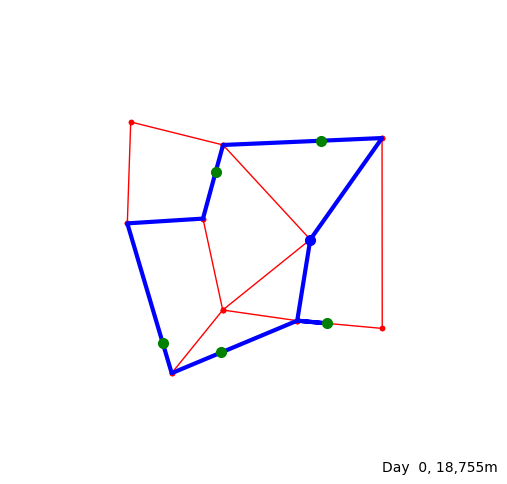

[ 0] 18:07:30.0 Driver leaves for delivery of 9 parcels
[ 0] 18:07:30.0 Driver drives to Customer:  4 (6698, 7149)
[ 0] 18:23:27.1 Driver arrived at Customer:  4 (6698, 7149)
[ 0] 18:24:10.9 Driver drives to Customer:  1 (4421, 6466)
[ 0] 18:35:05.9 Driver arrived at Customer:  1 (4421, 6466)
[ 0] 18:37:48.4 Driver drives to Customer:  3 (3285, 2769)
[ 0] 18:59:16.7 Driver arrived at Customer:  3 (3285, 2769)
[ 0] 18:59:53.2 Driver drives to Customer:  0 (4546, 2567)
[ 0] 19:07:14.1 Driver arrived at Customer:  0 (4546, 2567)
[ 0] 19:08:38.5 Driver drives to Customer:  2 (6818, 3195)
[ 0] 19:18:17.4 Driver arrived at Customer:  2 (6818, 3195)
[ 0] 19:18:47.3 Driver returns to delivery centre
[ 0] 19:28:28.3 Driver arrived at delivery centre
[ 1] 08:58:50.3 Parcel:  9 arr at delivery centre
[ 1] 11:39:15.5 Parcel: 10 arr at delivery centre
[ 1] 12:26:28.2 Parcel: 11 arr at delivery centre
[ 1] 12:48:42.10 Parcel: 12 arr at delivery centre
[ 1] 14:23:27.3 Parcel: 13 arr at delivery centr

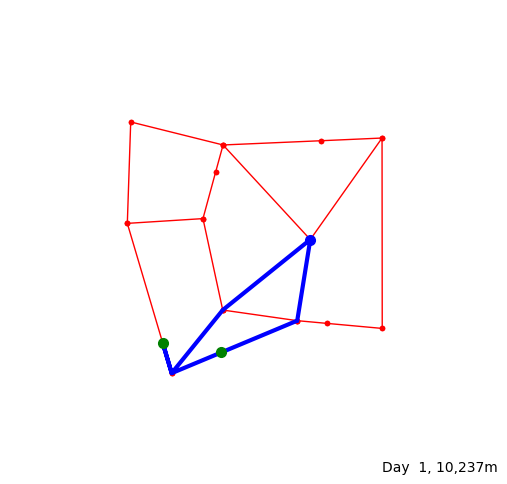

[ 1] 18:04:10.0 Driver leaves for delivery of 5 parcels
[ 1] 18:04:10.0 Driver drives to Customer:  3 (3285, 2769)
[ 1] 18:23:34.7 Driver arrived at Customer:  3 (3285, 2769)
[ 1] 18:24:24.1 Driver drives to Customer:  0 (4546, 2567)
[ 1] 18:31:45.0 Driver arrived at Customer:  0 (4546, 2567)
[ 1] 18:34:25.1 Driver returns to delivery centre
[ 1] 18:48:36.4 Driver arrived at delivery centre
[ 2] 09:04:43.10 Parcel: 14 arr at delivery centre
[ 2] 09:24:06.7 Parcel: 15 arr at delivery centre
[ 2] 12:05:44.2 Parcel: 16 arr at delivery centre
[ 2] 16:38:42.2 Parcel: 17 arr at delivery centre
[ 2] 18:00:00.0 Parcel: 14 out for delivery
[ 2] 18:00:00.0 Parcel: 17 out for delivery
[ 2] 18:00:00.0 Parcel: 15 out for delivery
[ 2] 18:00:00.0 Parcel: 16 out for delivery


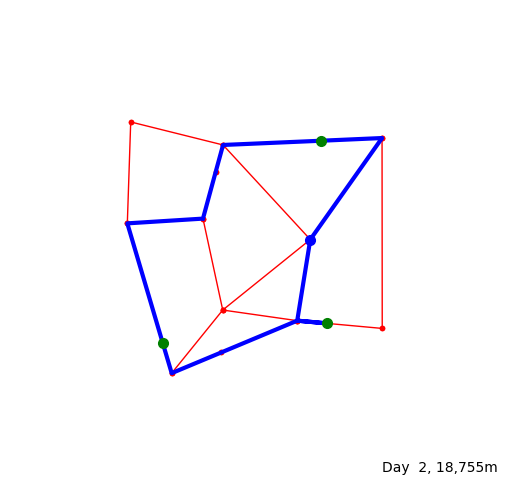

[ 2] 18:03:20.0 Driver leaves for delivery of 4 parcels
[ 2] 18:03:20.0 Driver drives to Customer:  2 (6818, 3195)
[ 2] 18:13:01.0 Driver arrived at Customer:  2 (6818, 3195)
[ 2] 18:13:50.6 Driver drives to Customer:  3 (3285, 2769)
[ 2] 18:30:22.9 Parcel: 18 arr at delivery centre
[ 2] 18:30:50.3 Driver arrived at Customer:  3 (3285, 2769)
[ 2] 18:31:15.2 Driver drives to Customer:  4 (6698, 7149)
[ 2] 19:03:38.5 Driver arrived at Customer:  4 (6698, 7149)
[ 2] 19:05:08.0 Driver returns to delivery centre
[ 2] 19:21:05.1 Driver arrived at delivery centre
[ 2] 21:06:35.2 Parcel: 19 arr at delivery centre
[ 3] 08:24:56.10 Parcel: 20 arr at delivery centre
[ 3] 09:52:53.7 Parcel: 21 arr at delivery centre
[ 3] 12:26:51.2 Parcel: 22 arr at delivery centre
[ 3] 13:44:15.9 Parcel: 23 arr at delivery centre
[ 3] 14:27:12.1 Parcel: 24 arr at delivery centre
[ 3] 18:00:00.0 Parcel: 18 out for delivery
[ 3] 18:00:00.0 Parcel: 19 out for delivery
[ 3] 18:00:00.0 Parcel: 22 out for delivery
[ 3]

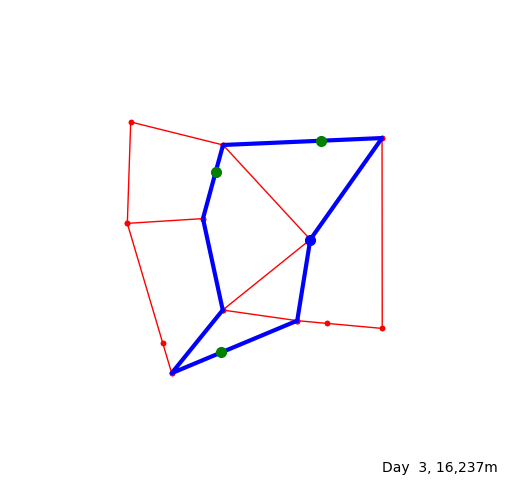

[ 3] 18:05:50.0 Driver leaves for delivery of 7 parcels
[ 3] 18:05:50.0 Driver drives to Customer:  0 (4546, 2567)
[ 3] 18:20:01.3 Driver arrived at Customer:  0 (4546, 2567)
[ 3] 18:21:06.9 Driver drives to Customer:  1 (4421, 6466)
[ 3] 18:45:00.4 Driver arrived at Customer:  1 (4421, 6466)
[ 3] 18:45:40.3 Driver drives to Customer:  4 (6698, 7149)
[ 3] 18:56:35.2 Driver arrived at Customer:  4 (6698, 7149)
[ 3] 18:57:11.1 Driver returns to delivery centre
[ 3] 19:13:08.2 Driver arrived at delivery centre


In [27]:
random.seed(0)
rec = simulation(M, W, C, D, log=True, plot=True)

## Adding Statistics and Visualisation

In [28]:
rec.daily

,driver_starts,driver_ends,distance,leftover,time
0,64800,70708,18.755,0,98.466667
1,151200,154716,10.237,0,58.6
2,237600,243065,18.755,0,91.083333
3,324000,328988,16.237,0,83.133333


In [29]:
def makePlot(df_attribute, title, xlabel, ylabel):
    fig, ax=plt.subplots(1,1)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.plot(df_attribute, color ='red', marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax.grid(True)
    plt.show()

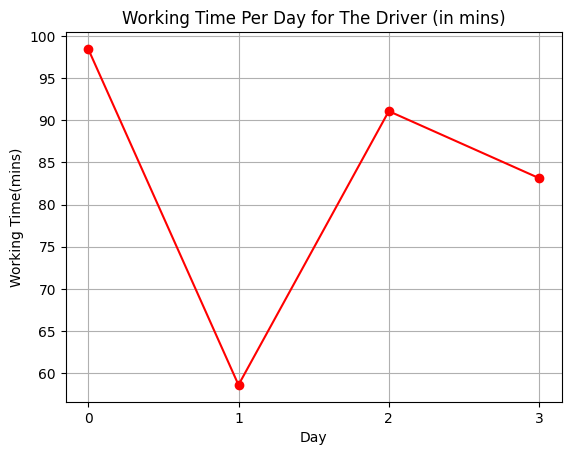

In [30]:
# Working time per day for the driver (in mins)
makePlot(rec.daily['time'],
         'Working Time Per Day for The Driver (in mins)',
         'Day', 'Working Time(mins)')

In [31]:
min(rec.daily['time'])

58.6

In [32]:
max(rec.daily['time'])

98.46666666666667

In [33]:
np.mean(rec.daily['time'])

82.82083333333333

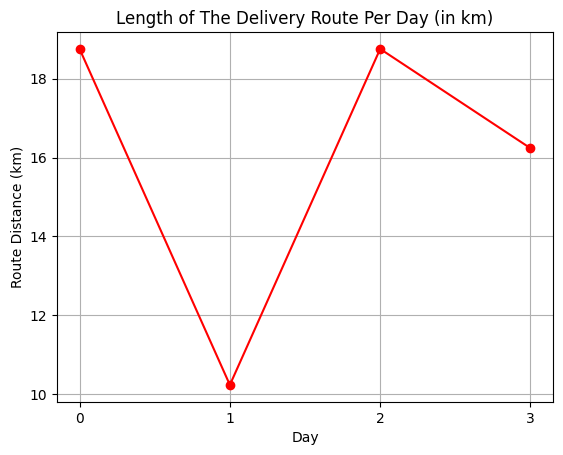

In [34]:
# length of the delivery route per day (in km)
makePlot(rec.daily['distance'], 
         'Length of The Delivery Route Per Day (in km)',
         'Day', 'Route Distance (km)')

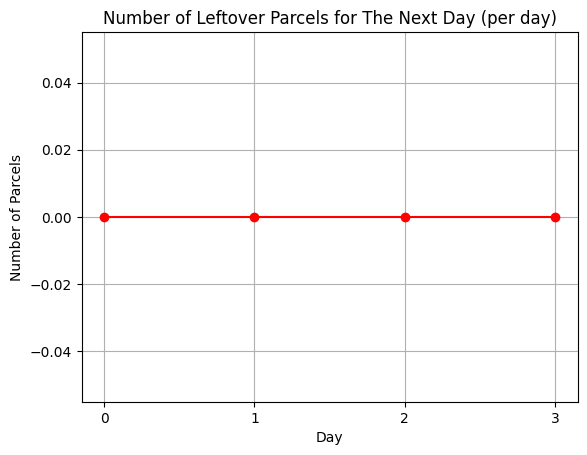

In [35]:
# Number of leftover parcels for the next day (per day)
makePlot(rec.daily['leftover'],
         'Number of Leftover Parcels for The Next Day (per day)',
         'Day', 'Number of Parcels')

In [36]:
rec.perParcel

,arrived,accepted,delay
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,0.0,0.0,0.0
8,0.0,0.0,0.0
9,1.0,1.0,0.0


In [37]:
rec.perParcel.to_csv('ParcelDelay.csv')

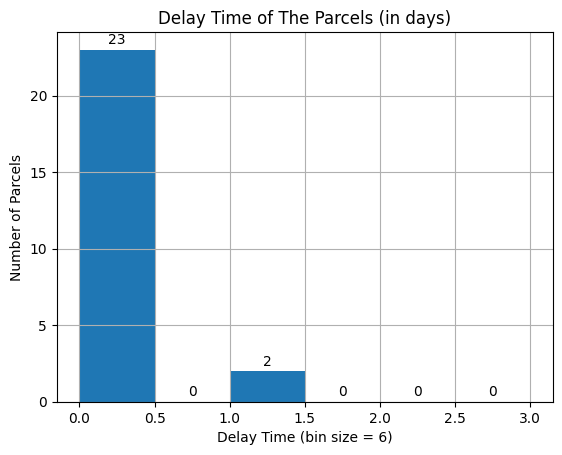

In [38]:
# Delay time of the parcels (in days)
data = rec.perParcel['delay']
bins = 6 # fixed bin size
fig, ax=plt.subplots(1,1)
#i = 0
#for day in rec17.perParcel['arrived']:
#    if day <= 21:
#        i+=1
#    else: break
#print('There are '+str(i)+' parcels have been delivered in 22 days.')        
# The range indicates delay time from 0 day to 3 days
plt.hist(rec.perParcel['delay'], bins=bins, range =[0,3])
plt.title('Delay Time of The Parcels (in days)')
plt.xlabel('Delay Time (bin size = 6)')
plt.ylabel('Number of Parcels')
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0,2), textcoords='offset points', ha='center', va='bottom') 
ax.grid(True)
plt.show()